UNet-Paper-Link:- https://arxiv.org/pdf/1505.04597v1.pdf

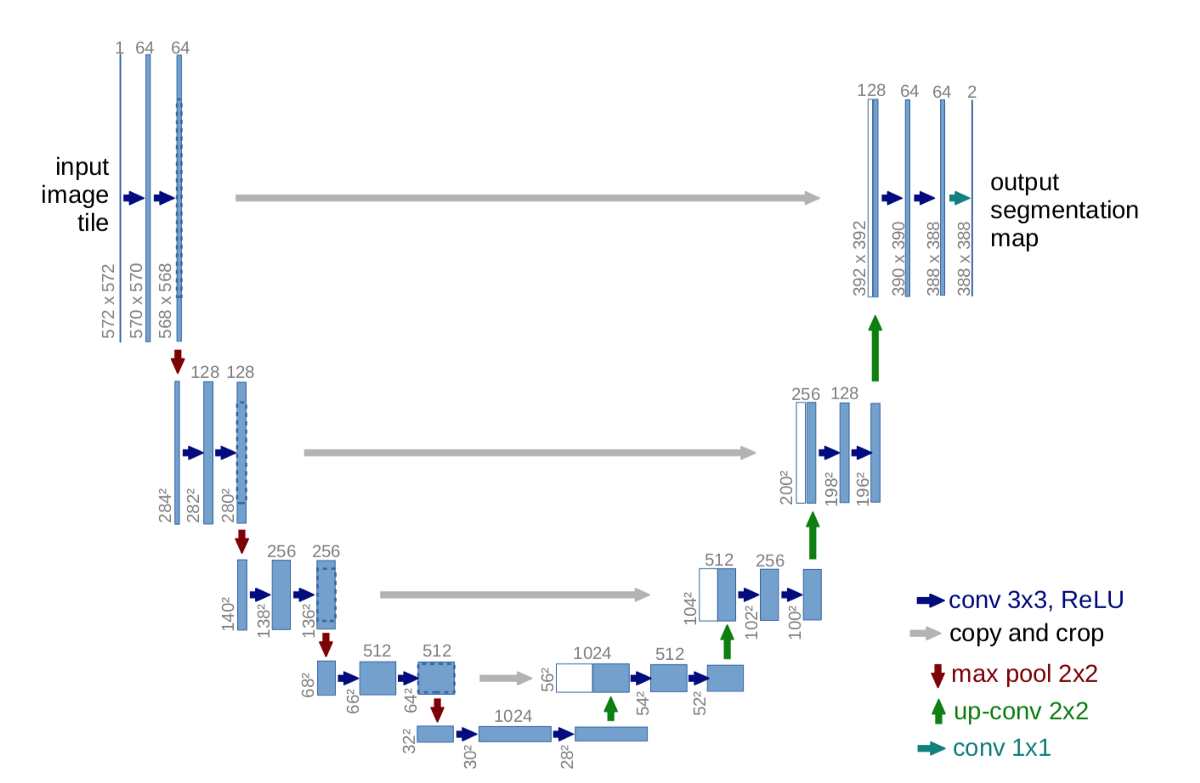

In [1]:
import torch
import torch.nn as nn

In [2]:
def double_conv(input_channel, output_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channels = input_channel, out_channels = output_channel, 
                  kernel_size = 3),
        nn.ReLU(inplace = True),
        
        nn.Conv2d(in_channels = output_channel, out_channels = output_channel, 
                  kernel_size = 3),
        nn.ReLU(inplace = True),
        )
    return conv


def crop_img_shape(original_tensor, target_tensor):
    original_size = original_tensor.shape[2]
    target_size = target_tensor.shape[2]
    delta = original_size - target_size
    delta = delta // 2
    return original_tensor[:, :, delta:original_size - delta, delta:original_size - delta]

In [3]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.img_shape_down_conv_1 = double_conv(input_channel = 3, output_channel = 64)
        self.img_shape_down_conv_2 = double_conv(input_channel = 64, output_channel = 128)
        self.img_shape_down_conv_3 = double_conv(input_channel = 128, output_channel = 256)
        self.img_shape_down_conv_4 = double_conv(input_channel = 256, output_channel = 512)
        self.img_shape_down_conv_5 = double_conv(input_channel = 512, output_channel = 1024)
        
        
        self.up_conv_trans_block_1 = nn.ConvTranspose2d(in_channels = 1024, 
                                                        out_channels = 512, 
                                                        kernel_size = 2, 
                                                        stride = 2)
        
        self.conv_1 = double_conv(input_channel = 1024, output_channel = 512)
        
        
        
        self.up_conv_trans_block_2 = nn.ConvTranspose2d(in_channels = 512, 
                                                        out_channels = 256, 
                                                        kernel_size = 2, 
                                                        stride = 2)
        
        self.conv_2 = double_conv(input_channel = 512, output_channel = 256)
        
        
        
        self.up_conv_trans_block_3 = nn.ConvTranspose2d(in_channels = 256, 
                                                        out_channels = 128, 
                                                        kernel_size = 2, 
                                                        stride = 2)
        
        self.conv_3 = double_conv(input_channel = 256, output_channel = 128)
        
        
        
        self.up_conv_trans_block_4 = nn.ConvTranspose2d(in_channels = 128, 
                                                        out_channels = 64, 
                                                        kernel_size = 2, 
                                                        stride = 2)
        
        self.conv_4 = double_conv(input_channel = 128, output_channel = 64)
        
        
        
        self.output_layer = nn.Conv2d(in_channels = 64, out_channels = 2, kernel_size = 1)
        
        
        
    def forward(self, x):
        # Encoder
        x1 = self.img_shape_down_conv_1(x)    #
        print(f"first down conv block {x1.shape}")
        x2 = self.max_pool_2x2(x1)  
        print(f"first maxpool block {x2.shape}")
        x3 = self.img_shape_down_conv_2(x2)   #
        x4 = self.max_pool_2x2(x3)
        x5 = self.img_shape_down_conv_3(x4)   #
        x6 = self.max_pool_2x2(x5)
        x7 = self.img_shape_down_conv_4(x6)   #
        x8 = self.max_pool_2x2(x7)
        x9 = self.img_shape_down_conv_5(x8)
        print(f"5th down conv block {x9.shape}")
        print()
        
        
        # Decoder
        # First Block
        x = self.up_conv_trans_block_1(x9)
        print(f"first trans block {x.shape}")
        print(f"To be concat with x7 {x7.shape}")
        y = crop_img_shape(original_tensor = x7, target_tensor = x)
        print(f"x7 after cropping: {y.shape}")
        print()
        print(
        f"""Now we can concat x7 which is of new shape {y.shape} with first trans block of shape {x.shape} to -
        - complete our first trans block with its final expected shape that is [BS, 1024, IMS=56, IMS=56]
        """)
        print()
        
        x = torch.cat([x, y], dim = 1)
        print(f"final fully completed first trans block shape: {x.shape}")
        
        x = self.conv_1(x)
        print(f"After first up conv block {x.shape}")
        print()
        
        
        # Second Block
        x = self.up_conv_trans_block_2(x)
        y = crop_img_shape(original_tensor = x5, target_tensor = x)
        x = torch.cat([x, y], dim = 1)
        x = self.conv_2(x)
        
        # Third Block
        x = self.up_conv_trans_block_3(x)
        y = crop_img_shape(original_tensor = x3, target_tensor = x)
        x = torch.cat([x, y], dim = 1)
        x = self.conv_3(x)
        
        # Fourth Block
        x = self.up_conv_trans_block_4(x)
        y = crop_img_shape(original_tensor = x1, target_tensor = x)
        x = torch.cat([x, y], dim = 1)
        x = self.conv_4(x)
        print(f"After Last up conv block {x.shape}")
        
        
        # Output Layer
        x = self.output_layer(x)
        print(f"Final Output Layer: {x.shape}")
        
        return x

In [4]:
randam_input = torch.rand(1, 3, 572, 572)
randam_input.shape

torch.Size([1, 3, 572, 572])

In [5]:
model = UNet()

In [6]:
model(randam_input).shape

first down conv block torch.Size([1, 64, 568, 568])
first maxpool block torch.Size([1, 64, 284, 284])
5th down conv block torch.Size([1, 1024, 28, 28])

first trans block torch.Size([1, 512, 56, 56])
To be concat with x7 torch.Size([1, 512, 64, 64])
x7 after cropping: torch.Size([1, 512, 56, 56])

Now we can concat x7 which is of new shape torch.Size([1, 512, 56, 56]) with first trans block of shape torch.Size([1, 512, 56, 56]) to -
        - complete our first trans block with its final expected shape that is [BS, 1024, IMS=56, IMS=56]
        

final fully completed first trans block shape: torch.Size([1, 1024, 56, 56])
After first up conv block torch.Size([1, 512, 52, 52])

After Last up conv block torch.Size([1, 64, 388, 388])
Final Output Layer: torch.Size([1, 2, 388, 388])


torch.Size([1, 2, 388, 388])